In [1]:
import sarracen
from sklearn.neighbors import KDTree
import numpy as np
import pandas as pd
from statistics import mean
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Finding gas neighbours of dust particles in the 2-fluid method

In [2]:
sdf_g, sdf_d = sarracen.read_phantom('2fluid/2f3mic256_00160', separate_types='all')

/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)
/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)


In [3]:
sdf_g.calc_density()
sdf_d.calc_density()

In [ ]:
# First find the dust neighbours of gas particles
def find_neighbours(sdf_g, sdf_d):

    sdf_tmp = sdf_d.copy()
    hmax = 2 * sdf_d.h.max()

    sdf_s1 = sdf_tmp[sdf_tmp.x + hmax - 1.0 > 0.0].copy()
    sdf_s2 = sdf_tmp[sdf_tmp.x - hmax + 1.0 < 1.0].copy()
    sdf_s3 = sdf_tmp[sdf_tmp.y + hmax - 1.0 > 0.0].copy()
    sdf_s4 = sdf_tmp[sdf_tmp.y - hmax + 1.0 < 1.0].copy()
    sdf_s5 = sdf_tmp[sdf_tmp.z + hmax - 1.0 > 0.0].copy()
    sdf_s6 = sdf_tmp[sdf_tmp.z - hmax + 1.0 < 1.0].copy()
    sdf_s1['x'] = sdf_s1['x'] - 1.0
    sdf_s2['x'] = sdf_s2['x'] + 1.0
    sdf_s3['y'] = sdf_s3['y'] - 1.0
    sdf_s4['y'] = sdf_s4['y'] + 1.0
    sdf_s5['z'] = sdf_s5['z'] - 1.0
    sdf_s6['z'] = sdf_s6['z'] + 1.0

    # corners
    c1 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)].copy()
    c2 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 < 1.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)].copy()
    c3 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax + 1.0 < 1.0)].copy()
    c4 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 < 1.0)
                    & (sdf_tmp.y + hmax + 1.0 < 1.0)].copy()

    c5 = sdf_tmp[(sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    c6 = sdf_tmp[(sdf_tmp.y + hmax + 1.0 < 1.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    c7 = sdf_tmp[(sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 < 1.0)].copy()
    c8 = sdf_tmp[(sdf_tmp.y + hmax + 1.0 < 1.0)
                    & (sdf_tmp.z + hmax + 1.0 < 1.0)].copy()

    c9 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    c10 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 < 1.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    c11 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 < 1.0)].copy()
    c12 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 < 1.0)
                    & (sdf_tmp.z + hmax + 1.0 < 1.0)].copy()

    c1['x'] = c1['x'] - 1.0
    c1['y'] = c1['y'] - 1.0
    c2['x'] = c2['x'] + 1.0
    c2['y'] = c2['y'] - 1.0
    c3['x'] = c3['x'] - 1.0
    c3['y'] = c3['y'] + 1.0
    c4['x'] = c4['x'] + 1.0
    c4['y'] = c4['y'] + 1.0

    c5['y'] = c5['y'] - 1.0
    c5['z'] = c5['z'] - 1.0
    c6['y'] = c6['y'] + 1.0
    c6['z'] = c6['z'] - 1.0
    c7['y'] = c7['y'] - 1.0
    c7['z'] = c7['z'] + 1.0
    c8['y'] = c8['y'] + 1.0
    c8['z'] = c8['z'] + 1.0

    c9['x'] = c9['x'] - 1.0
    c9['z'] = c9['z'] - 1.0
    c10['x'] = c10['x'] + 1.0
    c10['z'] = c10['z'] - 1.0
    c11['x'] = c11['x'] - 1.0
    c11['z'] = c11['z'] + 1.0
    c12['x'] = c12['x'] + 1.0
    c12['z'] = c12['z'] + 1.0


    # more corners
    sdf_c1 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    sdf_c2 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 > 0.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    sdf_c3 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax + 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    sdf_c4 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 > 0.0)
                    & (sdf_tmp.y + hmax + 1.0 > 0.0)
                    & (sdf_tmp.z + hmax - 1.0 > 0.0)].copy()
    sdf_c5 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 > 0.0)].copy()
    sdf_c6 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 > 0.0)
                    & (sdf_tmp.y + hmax - 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 > 0.0)].copy()
    sdf_c7 = sdf_tmp[(sdf_tmp.x + hmax - 1.0 > 0.0)
                    & (sdf_tmp.y + hmax + 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 > 0.0)].copy()
    sdf_c8 = sdf_tmp[(sdf_tmp.x + hmax + 1.0 > 0.0)
                    & (sdf_tmp.y + hmax + 1.0 > 0.0)
                    & (sdf_tmp.z + hmax + 1.0 > 0.0)].copy()
    sdf_c1['x'] = sdf_c1['x'] - 1.0
    sdf_c1['y'] = sdf_c1['y'] - 1.0
    sdf_c1['z'] = sdf_c1['z'] - 1.0

    sdf_c2['x'] = sdf_c2['x'] + 1.0
    sdf_c2['y'] = sdf_c2['y'] - 1.0
    sdf_c2['z'] = sdf_c2['z'] - 1.0

    sdf_c3['x'] = sdf_c3['x'] - 1.0
    sdf_c3['y'] = sdf_c3['y'] + 1.0
    sdf_c3['z'] = sdf_c3['z'] - 1.0

    sdf_c4['x'] = sdf_c4['x'] + 1.0
    sdf_c4['y'] = sdf_c4['y'] + 1.0
    sdf_c4['z'] = sdf_c4['z'] - 1.0

    sdf_c5['x'] = sdf_c5['x'] - 1.0
    sdf_c5['y'] = sdf_c5['y'] - 1.0
    sdf_c5['z'] = sdf_c5['z'] + 1.0

    sdf_c6['x'] = sdf_c6['x'] + 1.0
    sdf_c6['y'] = sdf_c6['y'] - 1.0
    sdf_c6['z'] = sdf_c6['z'] + 1.0

    sdf_c7['x'] = sdf_c7['x'] - 1.0
    sdf_c7['y'] = sdf_c7['y'] + 1.0
    sdf_c7['z'] = sdf_c7['z'] + 1.0

    sdf_c8['x'] = sdf_c8['x'] + 1.0
    sdf_c8['y'] = sdf_c8['y'] + 1.0
    sdf_c8['z'] = sdf_c8['z'] + 1.0

    sdf_tmp = pd.concat([sdf_tmp, sdf_s1, sdf_s2, sdf_s3, sdf_s4, sdf_s5, sdf_s6,
                        c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12,
                        sdf_c1, sdf_c2, sdf_c3, sdf_c4, sdf_c5, sdf_c6, sdf_c7, sdf_c8]).reset_index()


    # Built tree with periodic dust particles
    tree = KDTree(sdf_tmp[['x', 'y', 'z']].to_numpy(), leaf_size=10)

    # Search using gas particle positions and smoothing lengths
    neighbours = tree.query_radius(sdf_g[['x', 'y', 'z']].to_numpy().reshape(-1, 3), r=2*sdf_g.h)
    

    return neighbours, sdf_tmp

In [ ]:
neighbours, sdf_tmp = find_neighbours(sdf_g, sdf_d)

In [ ]:
# initialize strucure to hold gas neighbours of each dust particle
dust_neighbours = []
for i in range(len(neighbours)):
    b = np.array([], dtype=np.int64)
    dust_neighbours.append(b)

In [ ]:
# loop over each gas-dust neighbour pair
for gas_particle in range(len(neighbours)):
    
        
    for dust_neighbour in neighbours[gas_particle]:
        
        if dust_neighbour >= len(sdf_d):
            dust_neighbour = sdf_tmp.loc[dust_neighbour, 'index'] - 16777216
            
        dust_neighbours[dust_neighbour] = np.append(dust_neighbours[dust_neighbour], int(gas_particle))


In [ ]:
with open('dust_neighbours.pkl', 'wb') as file:
    pickle.dump(dust_neighbours, file)

# Interpolate the density and velocity of gas particle neighbours at dust particle locations

In [ ]:
# Read dust neighbours file 
with open('dust_neighbours.pkl', 'rb') as file:
    dust_neighbours = pickle.load(file)

In [ ]:
mass = 5.900860E-08
sigma = 1/np.pi
rhog = []
vx = []
vy = []
vz = []

for ind, array in enumerate(dust_neighbours):
    vx_neighb = 0
    vy_neighb = 0
    vz_neighb = 0    
    neighbor_rho = 0
    
    rho_dust = sdf_d.loc[16777216 + ind, 'rho']
    r_dust = sdf_d.loc[16777216  + ind, ['x', 'y', 'z']]
    v_dust = sdf_d.loc[16777216 + ind, ['vx', 'vy', 'vz']]


    
    for j in range(len(array)):
        
        rho_gas = sdf_g.loc[array[j], 'rho']
        r_gas = sdf_g.loc[array[j], ['x', 'y', 'z']]
        h_gas = sdf_g.loc[array[j], 'h']
        vx_gas = sdf_g.loc[array[j], 'vx']
        vy_gas = sdf_g.loc[array[j], 'vy']
        vz_gas = sdf_g.loc[array[j], 'vz']
        
        # cubic kernel
        q = np.linalg.norm(r_gas - r_dust) / h_gas
        if q < 1:
            f_q = 1 - 1.5 * q**2 + 0.75 * q**3
        elif q < 2:
            f_q = 0.25 * (2 - q)**3
        else:
            f_q = 0

        neighbor_rho += mass * sigma * f_q / h_gas**3
        vx_neighb += vx_gas * mass * sigma * f_q / (h_gas**3 * rho_gas)
        vy_neighb += vy_gas * mass * sigma * f_q / (h_gas**3 * rho_gas)
        vz_neighb += vz_gas * mass * sigma * f_q / (h_gas**3 * rho_gas)

        
    rhog.append(neighbor_rho)   
    vx.append(vx_neighb)
    vy.append(vy_neighb)
    vz.append(vz_neighb)


In [ ]:
df = pd.DataFrame({'vx_g': vx, 'vy_g': vy, 'vz_g': vz, 'rho_g' : rhog})

In [ ]:
df.to_csv('3mic_v_rho.csv', index = False)

# Stopping time of dust particles in the 2-fluid method

In [4]:
df = pd.read_csv('3mic_v_rho.csv')

In [5]:
df.index = df.index + 16777216
sdf_d_tmp = sdf_d.merge(df,  left_index=True, right_index=True)

/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)
/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)


In [6]:
vx_diff = sdf_d_tmp['vx_g'] - sdf_d_tmp['vx']
vy_diff = sdf_d_tmp['vy_g'] - sdf_d_tmp['vy']
vz_diff = sdf_d_tmp['vz_g'] - sdf_d_tmp['vz']

In [7]:
diffs_array = np.column_stack((vx_diff, vy_diff, vz_diff))

In [8]:
rho_grain=3.000E+20
sgrain=1.080E-22*0.3
gamma=1
    
sdf_d_tmp['tstop'] = np.sqrt(np.pi*gamma*0.125)*rho_grain*sgrain/(sdf_d_tmp['rho']+sdf_d_tmp['rho_g'])
sdf_d_tmp['tstop_f'] = np.sqrt(np.pi*gamma*0.125)*rho_grain*sgrain/(sdf_d_tmp['rho']+sdf_d_tmp['rho_g'])/np.sqrt(1+0.0703125*np.pi*(np.linalg.norm(diffs_array, axis=1))**2)

In [9]:
sdf_d_tmp = sdf_d_tmp[['rho','rho_g', 'tstop', 'tstop_f']]

/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)


In [10]:
sdf_d_tmp.to_csv('df_tstop.csv', index= False)

# Stokes number per dust particle in 2-fluid

In [4]:
sdf_d_tmp = pd.read_csv('df_tstop.csv')

In [5]:
sdf_d_tmp['h_g'] = 1.2*5.900860E-08**(1/3)/sdf_d_tmp['rho_g']**(1/3) 

In [6]:
# Stokes number without the turvulence correction factor
sdf_d_tmp['St'] = sdf_d_tmp['tstop']/sdf_d_tmp['h_g']

# Stokes number with the turbulence correction factor (f)
sdf_d_tmp['St_f'] = sdf_d_tmp['tstop_f']/sdf_d_tmp['h_g']

In [7]:
sdf_d.reset_index(drop=True, inplace=True)

In [8]:
# Add Stokes number to the dust data 
sdf_d['stokes'] = sdf_d_tmp['St_f']

# Stokes number in 1-fluid

In [9]:
sdf_1f = sarracen.read_phantom('limited/3mic256l_00160')

/users/labnet6/gr2/nvadood/virtual-env/lib/python3.8/site-packages/numba/cuda/cudadrv/nvvm.py:400: UserWarning: CUDA Toolkit 10.1 is unsupported by Numba - 11.0 is the minimum required version.
  warnings.warn(unsupported_ver)


In [10]:
grid_g= sdf_g.sph_interpolate('rho', x_pixels=256, y_pixels=256, z_pixels=256, backend='cpu').flatten()

In [11]:
sdf_1f.calc_density()

In [12]:
# limiting the stopping time to be less than h (c_s = 1)
sdf_1f['limited-tstop'] = sdf_1f.apply(lambda row: row['tstop'] if row['tstop'] < row['h'] else row['h'], axis=1)

In [13]:
st_lim = sdf_1f['limited-tstop']/sdf_1f['h']
St_1f = pd.DataFrame()
St_1f['value'], bins = np.histogram(np.log10(st_lim), bins=120, range=(-2, 2))
St_1f['value'] = St_1f['value']/St_1f['value'].sum()
St_1f['bins'] = bins[:120]

In [14]:
st_2f_f = sdf_d_tmp['tstop_f']/sdf_d_tmp['h_g']
St_2f_f = pd.DataFrame()
St_2f_f['value'], bins = np.histogram(np.log10(st_2f_f), bins=120, range=(-2, 2))
St_2f_f['value'] = St_2f_f['value']/St_2f_f['value'].sum()
St_2f_f['bins'] = bins[:120]

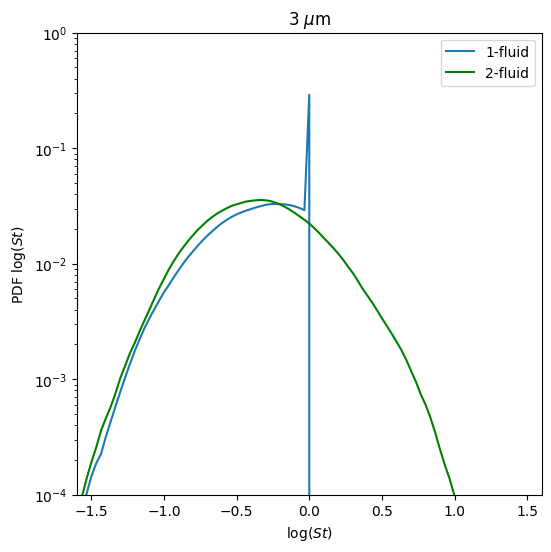

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.lineplot(data=St_1f, x='bins', y='value', ax=ax, errorbar='sd', label = '1-fluid')
ax = sns.lineplot(data=St_2f_f, x='bins', y='value', ax=ax, errorbar='sd', color = 'green', label = '2-fluid')
ax.legend()
ax.set_yscale('log')
ax.set_ylim((1e-4, 1))
ax.set_xlim((-1.6, 1.6))
# ax.set_xscale('log')
ax.set(xlabel=r'$\log(St)$',
       ylabel=r'PDF $\log(St)$',
       title=r'3 $\mu$m')
fig.savefig('stokes_dist_3mic_log.pdf')

# Fraction of grids with St = 1 in the limited 1-fluid method

In [16]:
st_lim[st_lim == 1.0].sum() / len(st_lim)

0.2907869219779968